In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [34]:
mean_std_data = datasets.FashionMNIST('./FashionMNIST_data', train=True, download=True, transform=transforms.ToTensor()).train_data.float() / 255
mean = torch.mean(mean_std_data)
std = torch.std(mean_std_data)
print(mean, std)

tensor(0.2860) tensor(0.3530)


In [35]:
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
           ])

In [36]:
def fashion_mnist(batch_size=50, valid=0, shuffle=True, transform=fashion_transform, path='./FashionMNIST_data'):
    test_data = datasets.FashionMNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.FashionMNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [37]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=10000)

In [78]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [102]:
models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [103]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    
    train_loss = {k: 0. for k in models}
    correct_train = {k: 0. for k in models}
    
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
            train_loss[k] += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct_train[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
        
    if log is not None:
        for k in models:
            train_loss[k] /= train_size
        correct_pct = {k: 100. * correct_train[k] / train_size for k in correct_train}
        for k in models:
            log[k].append((train_loss[k], correct_pct[k])) 

In [104]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [105]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.331291 bn: 2.278652 drop: 2.331962 both: 2.348996
Train Epoch: 1 [10000/50000 (20%)]	Losses default: 0.685427 bn: 0.719545 drop: 0.798058 both: 0.840657
Train Epoch: 1 [20000/50000 (40%)]	Losses default: 0.851417 bn: 0.850554 drop: 0.910619 both: 0.917774
Train Epoch: 1 [30000/50000 (60%)]	Losses default: 0.600205 bn: 0.616935 drop: 0.735857 both: 0.656695
Train Epoch: 1 [40000/50000 (80%)]	Losses default: 0.470521 bn: 0.460204 drop: 0.498184 both: 0.516877
Train Epoch: 1 [50000/50000 (100%)]	Losses default: 0.446340 bn: 0.444544 drop: 0.443424 both: 0.498681
Test set:
default: Loss: 0.4815	Accuracy: 8345.0/10000 (83%)
bn: Loss: 0.4543	Accuracy: 8453.0/10000 (85%)
drop: Loss: 0.5330	Accuracy: 8176.0/10000 (82%)
both: Loss: 0.5042	Accuracy: 8296.0/10000 (83%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.378561 bn: 0.337549 drop: 0.434455 both: 0.428562
Train Epoch: 2 [10000/50000 (20%)]	Losses default: 0.462777 bn: 0.433162 drop: 0.504

Train Epoch: 11 [10000/50000 (20%)]	Losses default: 0.329106 bn: 0.346149 drop: 0.376371 both: 0.364316
Train Epoch: 11 [20000/50000 (40%)]	Losses default: 0.313983 bn: 0.378852 drop: 0.292159 both: 0.360051
Train Epoch: 11 [30000/50000 (60%)]	Losses default: 0.189438 bn: 0.206274 drop: 0.231485 both: 0.147942
Train Epoch: 11 [40000/50000 (80%)]	Losses default: 0.366867 bn: 0.332868 drop: 0.436621 both: 0.449432
Train Epoch: 11 [50000/50000 (100%)]	Losses default: 0.342734 bn: 0.249840 drop: 0.285793 both: 0.352770
Test set:
default: Loss: 0.3174	Accuracy: 8861.0/10000 (89%)
bn: Loss: 0.3059	Accuracy: 8882.0/10000 (89%)
drop: Loss: 0.3439	Accuracy: 8769.0/10000 (88%)
both: Loss: 0.3263	Accuracy: 8817.0/10000 (88%)

Train Epoch: 12 [0/50000 (0%)]	Losses default: 0.294720 bn: 0.268909 drop: 0.282365 both: 0.366331
Train Epoch: 12 [10000/50000 (20%)]	Losses default: 0.302688 bn: 0.309063 drop: 0.429773 both: 0.326449
Train Epoch: 12 [20000/50000 (40%)]	Losses default: 0.184347 bn: 0.17799

Train Epoch: 21 [10000/50000 (20%)]	Losses default: 0.362348 bn: 0.307870 drop: 0.418902 both: 0.344736
Train Epoch: 21 [20000/50000 (40%)]	Losses default: 0.255846 bn: 0.217296 drop: 0.335193 both: 0.217090
Train Epoch: 21 [30000/50000 (60%)]	Losses default: 0.132532 bn: 0.153543 drop: 0.184137 both: 0.196760
Train Epoch: 21 [40000/50000 (80%)]	Losses default: 0.224746 bn: 0.266601 drop: 0.241957 both: 0.277784
Train Epoch: 21 [50000/50000 (100%)]	Losses default: 0.095202 bn: 0.080376 drop: 0.109161 both: 0.128789
Test set:
default: Loss: 0.2984	Accuracy: 8935.0/10000 (89%)
bn: Loss: 0.2944	Accuracy: 8961.0/10000 (90%)
drop: Loss: 0.3224	Accuracy: 8860.0/10000 (89%)
both: Loss: 0.3139	Accuracy: 8933.0/10000 (89%)

Train Epoch: 22 [0/50000 (0%)]	Losses default: 0.097516 bn: 0.097954 drop: 0.124292 both: 0.141201
Train Epoch: 22 [10000/50000 (20%)]	Losses default: 0.131808 bn: 0.153258 drop: 0.175136 both: 0.204572
Train Epoch: 22 [20000/50000 (40%)]	Losses default: 0.186905 bn: 0.14253

Train Epoch: 31 [10000/50000 (20%)]	Losses default: 0.204176 bn: 0.294766 drop: 0.283770 both: 0.285396
Train Epoch: 31 [20000/50000 (40%)]	Losses default: 0.124021 bn: 0.075754 drop: 0.106012 both: 0.096832
Train Epoch: 31 [30000/50000 (60%)]	Losses default: 0.056504 bn: 0.054521 drop: 0.046764 both: 0.081055
Train Epoch: 31 [40000/50000 (80%)]	Losses default: 0.141487 bn: 0.161285 drop: 0.182883 both: 0.261670
Train Epoch: 31 [50000/50000 (100%)]	Losses default: 0.086003 bn: 0.148588 drop: 0.119385 both: 0.216560
Test set:
default: Loss: 0.3102	Accuracy: 8933.0/10000 (89%)
bn: Loss: 0.3235	Accuracy: 8919.0/10000 (89%)
drop: Loss: 0.3145	Accuracy: 8913.0/10000 (89%)
both: Loss: 0.3236	Accuracy: 8890.0/10000 (89%)

Train Epoch: 32 [0/50000 (0%)]	Losses default: 0.144750 bn: 0.156162 drop: 0.299347 both: 0.213557
Train Epoch: 32 [10000/50000 (20%)]	Losses default: 0.249207 bn: 0.113032 drop: 0.253006 both: 0.180489
Train Epoch: 32 [20000/50000 (40%)]	Losses default: 0.225362 bn: 0.18738

Train Epoch: 41 [10000/50000 (20%)]	Losses default: 0.053655 bn: 0.073550 drop: 0.085073 both: 0.060904
Train Epoch: 41 [20000/50000 (40%)]	Losses default: 0.099738 bn: 0.180800 drop: 0.144014 both: 0.263854
Train Epoch: 41 [30000/50000 (60%)]	Losses default: 0.096302 bn: 0.093440 drop: 0.093412 both: 0.159610
Train Epoch: 41 [40000/50000 (80%)]	Losses default: 0.240573 bn: 0.183964 drop: 0.208913 both: 0.154841
Train Epoch: 41 [50000/50000 (100%)]	Losses default: 0.081437 bn: 0.054868 drop: 0.078412 both: 0.081607
Test set:
default: Loss: 0.3321	Accuracy: 8935.0/10000 (89%)
bn: Loss: 0.3437	Accuracy: 8955.0/10000 (90%)
drop: Loss: 0.3301	Accuracy: 8900.0/10000 (89%)
both: Loss: 0.3420	Accuracy: 8882.0/10000 (89%)

Train Epoch: 42 [0/50000 (0%)]	Losses default: 0.071296 bn: 0.022578 drop: 0.113838 both: 0.081611
Train Epoch: 42 [10000/50000 (20%)]	Losses default: 0.263707 bn: 0.161275 drop: 0.304910 both: 0.206492
Train Epoch: 42 [20000/50000 (40%)]	Losses default: 0.103511 bn: 0.09040

Train Epoch: 51 [10000/50000 (20%)]	Losses default: 0.080862 bn: 0.140666 drop: 0.117617 both: 0.089544
Train Epoch: 51 [20000/50000 (40%)]	Losses default: 0.102856 bn: 0.090842 drop: 0.214831 both: 0.143807
Train Epoch: 51 [30000/50000 (60%)]	Losses default: 0.107573 bn: 0.079572 drop: 0.261604 both: 0.137608
Train Epoch: 51 [40000/50000 (80%)]	Losses default: 0.067998 bn: 0.071457 drop: 0.069548 both: 0.110765
Train Epoch: 51 [50000/50000 (100%)]	Losses default: 0.064822 bn: 0.061123 drop: 0.065206 both: 0.086082
Test set:
default: Loss: 0.3746	Accuracy: 8907.0/10000 (89%)
bn: Loss: 0.3843	Accuracy: 8941.0/10000 (89%)
drop: Loss: 0.3479	Accuracy: 8914.0/10000 (89%)
both: Loss: 0.3654	Accuracy: 8922.0/10000 (89%)

Train Epoch: 52 [0/50000 (0%)]	Losses default: 0.034132 bn: 0.074118 drop: 0.063071 both: 0.058564
Train Epoch: 52 [10000/50000 (20%)]	Losses default: 0.068337 bn: 0.070518 drop: 0.132798 both: 0.052113
Train Epoch: 52 [20000/50000 (40%)]	Losses default: 0.084442 bn: 0.09002

Train Epoch: 61 [10000/50000 (20%)]	Losses default: 0.056790 bn: 0.030641 drop: 0.075165 both: 0.119397
Train Epoch: 61 [20000/50000 (40%)]	Losses default: 0.027874 bn: 0.041451 drop: 0.056954 both: 0.076916
Train Epoch: 61 [30000/50000 (60%)]	Losses default: 0.038753 bn: 0.039556 drop: 0.112893 both: 0.140239
Train Epoch: 61 [40000/50000 (80%)]	Losses default: 0.013315 bn: 0.052446 drop: 0.071620 both: 0.102398
Train Epoch: 61 [50000/50000 (100%)]	Losses default: 0.088987 bn: 0.061482 drop: 0.078348 both: 0.128561
Test set:
default: Loss: 0.4156	Accuracy: 8878.0/10000 (89%)
bn: Loss: 0.4011	Accuracy: 8928.0/10000 (89%)
drop: Loss: 0.3767	Accuracy: 8914.0/10000 (89%)
both: Loss: 0.3776	Accuracy: 8925.0/10000 (89%)

Train Epoch: 62 [0/50000 (0%)]	Losses default: 0.029641 bn: 0.026275 drop: 0.035264 both: 0.088989
Train Epoch: 62 [10000/50000 (20%)]	Losses default: 0.020590 bn: 0.022597 drop: 0.052960 both: 0.067137
Train Epoch: 62 [20000/50000 (40%)]	Losses default: 0.085607 bn: 0.15391

Train Epoch: 71 [10000/50000 (20%)]	Losses default: 0.060395 bn: 0.044088 drop: 0.029989 both: 0.074448
Train Epoch: 71 [20000/50000 (40%)]	Losses default: 0.012527 bn: 0.047109 drop: 0.039931 both: 0.044730
Train Epoch: 71 [30000/50000 (60%)]	Losses default: 0.028220 bn: 0.100878 drop: 0.154140 both: 0.120804
Train Epoch: 71 [40000/50000 (80%)]	Losses default: 0.061519 bn: 0.100475 drop: 0.081619 both: 0.085803
Train Epoch: 71 [50000/50000 (100%)]	Losses default: 0.005357 bn: 0.013088 drop: 0.040868 both: 0.049722
Test set:
default: Loss: 0.4874	Accuracy: 8859.0/10000 (89%)
bn: Loss: 0.4317	Accuracy: 8932.0/10000 (89%)
drop: Loss: 0.4280	Accuracy: 8873.0/10000 (89%)
both: Loss: 0.4253	Accuracy: 8922.0/10000 (89%)

Train Epoch: 72 [0/50000 (0%)]	Losses default: 0.055700 bn: 0.031642 drop: 0.094073 both: 0.045579
Train Epoch: 72 [10000/50000 (20%)]	Losses default: 0.058621 bn: 0.075322 drop: 0.133458 both: 0.114375
Train Epoch: 72 [20000/50000 (40%)]	Losses default: 0.069701 bn: 0.15951

Train Epoch: 81 [10000/50000 (20%)]	Losses default: 0.011659 bn: 0.059906 drop: 0.032963 both: 0.056981
Train Epoch: 81 [20000/50000 (40%)]	Losses default: 0.005577 bn: 0.007545 drop: 0.019486 both: 0.046943
Train Epoch: 81 [30000/50000 (60%)]	Losses default: 0.016772 bn: 0.035612 drop: 0.034524 both: 0.095421
Train Epoch: 81 [40000/50000 (80%)]	Losses default: 0.008630 bn: 0.023234 drop: 0.014448 both: 0.024050
Train Epoch: 81 [50000/50000 (100%)]	Losses default: 0.013758 bn: 0.041822 drop: 0.106053 both: 0.116885
Test set:
default: Loss: 0.5162	Accuracy: 8888.0/10000 (89%)
bn: Loss: 0.4668	Accuracy: 8938.0/10000 (89%)
drop: Loss: 0.4493	Accuracy: 8903.0/10000 (89%)
both: Loss: 0.4473	Accuracy: 8895.0/10000 (89%)

Train Epoch: 82 [0/50000 (0%)]	Losses default: 0.005970 bn: 0.046573 drop: 0.036454 both: 0.010348
Train Epoch: 82 [10000/50000 (20%)]	Losses default: 0.094769 bn: 0.091890 drop: 0.089317 both: 0.025376
Train Epoch: 82 [20000/50000 (40%)]	Losses default: 0.006677 bn: 0.04115

Train Epoch: 91 [10000/50000 (20%)]	Losses default: 0.049551 bn: 0.042172 drop: 0.074408 both: 0.094416
Train Epoch: 91 [20000/50000 (40%)]	Losses default: 0.010157 bn: 0.045519 drop: 0.029890 both: 0.071877
Train Epoch: 91 [30000/50000 (60%)]	Losses default: 0.014114 bn: 0.038345 drop: 0.073398 both: 0.049052
Train Epoch: 91 [40000/50000 (80%)]	Losses default: 0.003163 bn: 0.032096 drop: 0.014879 both: 0.016329
Train Epoch: 91 [50000/50000 (100%)]	Losses default: 0.015023 bn: 0.006456 drop: 0.042149 both: 0.016775
Test set:
default: Loss: 0.5893	Accuracy: 8862.0/10000 (89%)
bn: Loss: 0.5017	Accuracy: 8919.0/10000 (89%)
drop: Loss: 0.4892	Accuracy: 8894.0/10000 (89%)
both: Loss: 0.4592	Accuracy: 8923.0/10000 (89%)

Train Epoch: 92 [0/50000 (0%)]	Losses default: 0.016905 bn: 0.017083 drop: 0.032744 both: 0.055084
Train Epoch: 92 [10000/50000 (20%)]	Losses default: 0.047217 bn: 0.042691 drop: 0.024910 both: 0.062615
Train Epoch: 92 [20000/50000 (40%)]	Losses default: 0.017528 bn: 0.08677

In [106]:
def plot_compare_logs(test_log, train_log):
    keys = test_log.keys()
    test_logs = {k:[z for z in zip(*test_log[k])] for k in keys}
    train_logs = {k:[z for z in zip(*train_log[k])] for k in keys}
    epochs = {k:range(len(test_log[k])) for k in keys}
    
    g_counter = 0
    for k in keys:        
        plt.subplot(4, 2, g_counter+1)
        plt.plot(epochs[k], test_logs[k][0], label='test loss')
        plt.plot(epochs[k], train_logs[k][0], label='train loss')
        plt.title(k + ' errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend()
        plt.grid()
        
        plt.subplot(4, 2, g_counter+2)
        plt.plot(epochs[k], test_logs[k][1], label='test accuracy')
        plt.plot(epochs[k], train_logs[k][1], label='train accuracy')
        plt.title(k + ' accuracy')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend()
        plt.grid()
        
        g_counter += 2

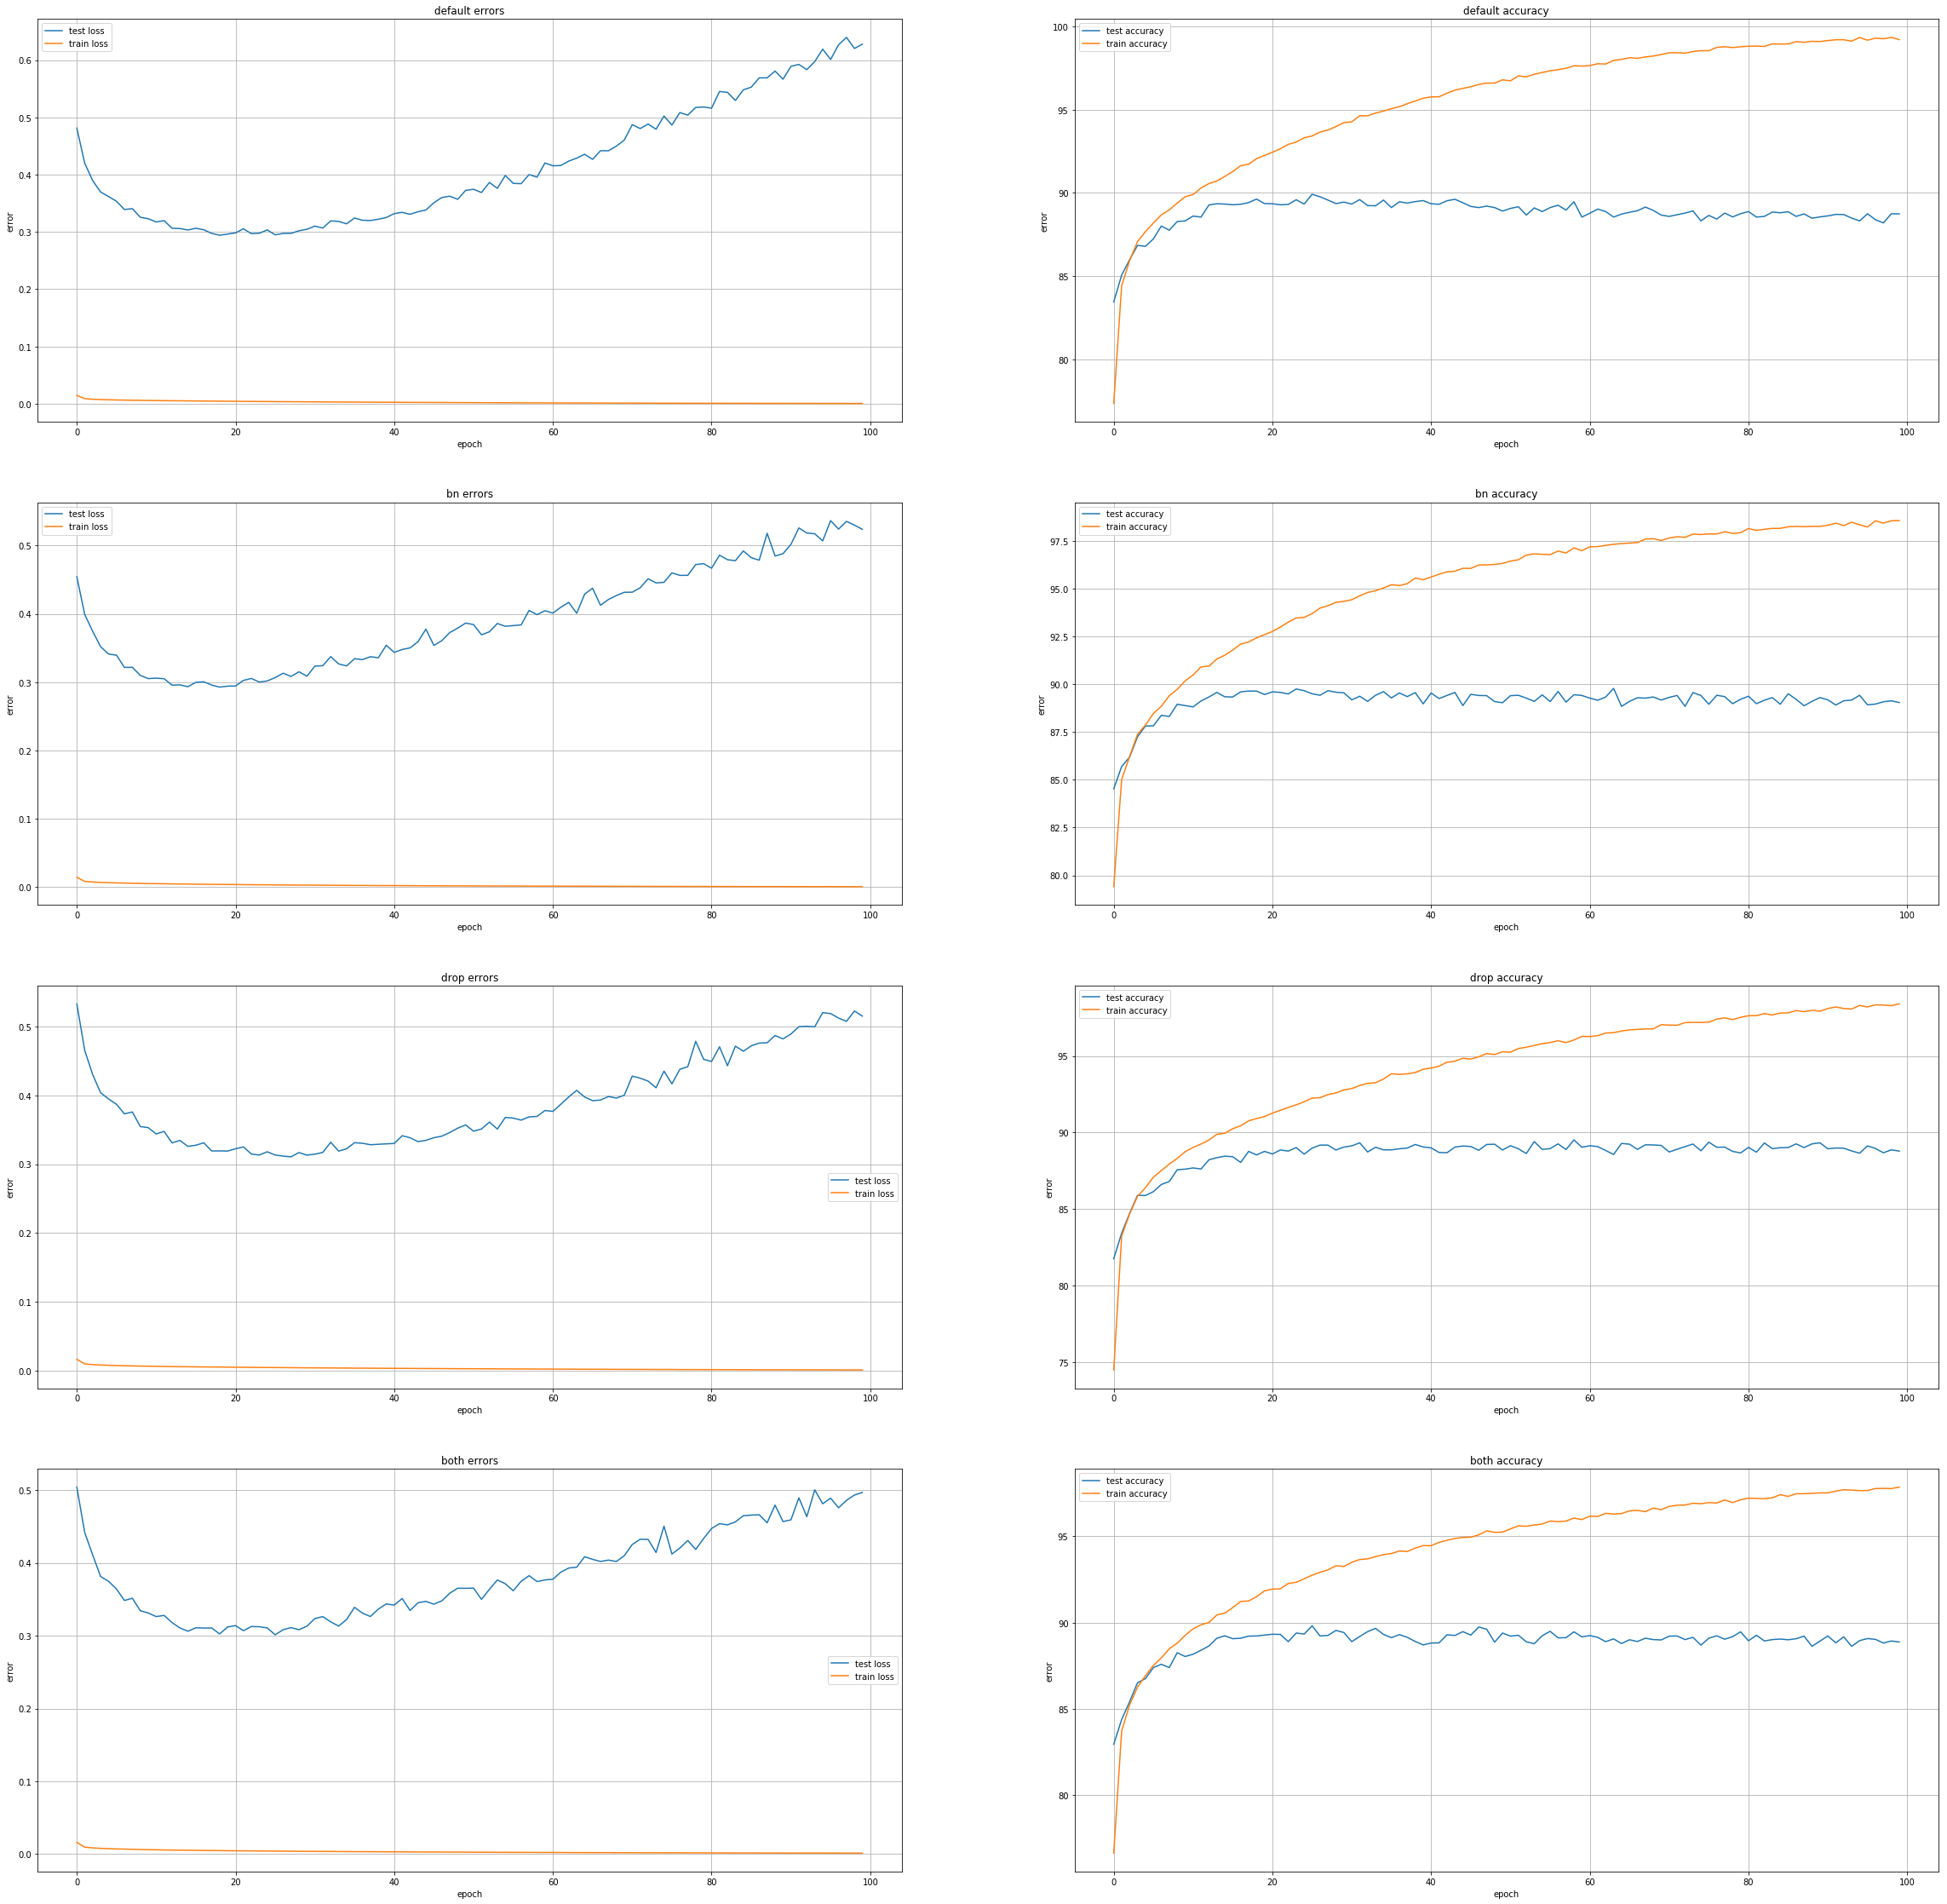

In [107]:
plt.rcParams['figure.figsize'] = [40, 40]
plot_compare_logs(test_log, train_log)